In [1]:
import pandas as pd
import numpy as np
import pickle
from cryptography.fernet import Fernet
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [163]:
df = pd.read_csv('original_data/relatorio_votos.csv')

In [130]:
df.keys()

Index(['Código', 'Data de criação', 'Autor', 'Título', 'Descrição',
       'Categoria', 'Resultado da priorização', 'Votos',
       'Resultado da votação', 'Viabilidade', 'Compromisso', 'Justificativa',
       'Data do voto', 'Horário', 'documento', 'subprefeitura'],
      dtype='object')

In [141]:
df['documento'].isnull().sum()

323

In [140]:
df[df['documento'].isnull()].groupby('Título').count()[['Código']].sort_values(by='Código', ascending=False)

,Código
Título,
"Retomada do Circo Escola, com reforma e investimentos no local",32
Iluminação interna e revitalização das praças Aureliano Leite e Mal. Bittencourt,27
"Implantação de Parque linear ao redor da SABESP, no Alto da Boa Vista.",24
"Troca dos brinquedos de praça na Av.Yervant Kissajikian, altura do número 272",22
Lombadas eletrônicas/radares de velocidade em frente a escolas que especifica,18
...,...
Implantar Programa Wi-fi Livre SP em todas as escolas da rede municipal,1
Implantar na região instituto de longa permanência para idoso,1
Implantação de Unidade Básica de Saúde na região do Largo da Batata,1


In [142]:
df[df['documento'].isnull()].groupby('subprefeitura').count()[['Código']].sort_values(by='Código', ascending=False)

,Código
subprefeitura,
Lapa,80
Santo Amaro,55
Butantã,55
Campo Limpo,30
Vila Mariana,22
Pinheiros,15
Santana/Tucuruvi,11
Aricanduva/Formosa/Carrão,7
Capela do Socorro,7


In [147]:
df[df['documento'].isnull()].groupby('Resultado da votação').count()[['Código']]

,Código
Resultado da votação,
Eleita,269
Não eleita,54


In [175]:
prop_eleitas = df[df['Resultado da votação']=='Eleita']['Título'].unique()

In [176]:
len(prop_eleitas)

154

In [166]:
df_limpo = df[df['documento'].notnull()].copy()

In [167]:
(len(df) - len(df_limpo)) == df['documento'].isnull().sum()

True

In [177]:
prop_sem_voto_zuado = df_limpo[df_limpo['Resultado da votação']=='Eleita']['Título'].unique()

In [178]:
len(prop_sem_voto_zuado)

154

In [179]:
[nom for nom in prop_eleitas if nom not in prop_sem_voto_zuado]

[]

In [174]:
df['Resultado da votação'].unique()

array(['Eleita', 'Não eleita'], dtype=object)

In [171]:
len(df['Título'].unique())

408

In [5]:
def hash_string(item):
    
    item = str(item).encode('utf-8')
    result = hashlib.md5(item)
    
    return result.hexdigest()

In [6]:
def hashear_autor_e_nome(df):

    df['Autor'].fillna('Vazio', inplace = True)
    df['documento'].fillna('Vazio', inplace = True)
    df['autor_hash'] = df['Autor'].apply(hash_string)
    df['documento_hash'] = df['documento'].apply(hash_string)
    
    #abaixo verificamos se as hashs funcionaram
    df['count'] = 1
    assert df.groupby('Autor').count()['count'].max() == df.groupby('autor_hash').count()['count'].max()
    assert df.groupby('documento').count()['count'].max() == df.groupby('documento_hash').count()['count'].max()
    df.drop('count', axis=1, inplace = True)

In [7]:
hashear_autor_e_nome(df)

In [8]:
def get_fernet_crypto():
    
    with open('original_data/fernet_key.pi', 'rb') as f:
        key = pickle.load(f)
        
    return Fernet(key)

In [9]:
def encrypt(item, crypto):
    
    bytes_item = str(item).encode('utf-8')
    
    return crypto.encrypt(bytes_item)

In [10]:
def str_bytes_to_bytes(item):
    
    if type(item) is str and \
    item.startswith("b"):
        
        item = item[2:-1].encode('utf-8')
        
    return item

In [11]:
def decrypt(item, crypto):
    
    item = str_bytes_to_bytes(item)
        
    return crypto.decrypt(item).decode('utf-8')

In [12]:
def encriptar_autor_e_doc(df):
    
    fernet = get_fernet_crypto()

    assert decrypt(encrypt('Henrique Pougy', fernet), fernet) == 'Henrique Pougy'
    
    df['Autor'].fillna('Vazio', inplace = True)
    df['Autor'] = df['Autor'].apply(encrypt,args = [fernet])
    df['documento'].fillna('Vazio', inplace = True)
    df['documento'] = df['documento'].apply(encrypt, args=[fernet])

In [13]:
encriptar_autor_e_doc(df)

In [14]:
def drop_cols_sem_info(df):
    
    df = df.copy()
    
    remover = []
    for col in df.columns:
        val_unicos = df[col].unique()
        if len(val_unicos) == 1:
            print(f'A coluna {col} possui como valor unico "{val_unicos[0]}"')
            remover.append(col)
    df.drop(remover, axis=1, inplace = True)
    
    return df

In [15]:
df = drop_cols_sem_info(df)

A coluna Resultado da priorização possui como valor unico "Priorizada"
A coluna Viabilidade possui como valor unico "Etapa orçamentária futura"
A coluna Compromisso possui como valor unico "Etapa orçamentária futura"
A coluna Justificativa possui como valor unico "Etapa orçamentária futura"


In [16]:
df_microdados = df.drop(['autor_hash', 'documento_hash'], axis = 1).copy()

In [17]:
df_microdados.to_csv('microdados_votacao_orcamento_anonimizados.csv', sep =';', index = False, encoding = 'utf-8')

In [18]:
df.head()

,Código,Data de criação,Autor,Título,Descrição,Categoria,Votos,Resultado da votação,Data do voto,Horário,documento,subprefeitura,autor_hash,documento_hash
0,335,17/04/2021,b'gAAAAABhAFwrirDZBbx6_LbGsQN0jxvuGzPQC_sLuPIg...,Implantação do Parque Cabeceira do Cabore,Implantação do Parque Cabeceira do Cabore Pl 7...,Meio Ambiente,491,Eleita,25/06/21,00:05,b'gAAAAABhAFwsdGTjzhpxJ9dZASoukm7sENPowbEANwPX...,Campo Limpo,e9217cc0466a467245b23c593967fce7,8fa3a4093acd9090e33d9e4068eede9f
1,81,13/04/2021,b'gAAAAABhAFwrptravNt9HFjUNbi9-eQMkxcA3gmPeXIt...,Implantação de UBS na região do parque industr...,Implantação de uma unidade básica de saúde na ...,Saúde,136,Não eleita,25/06/21,00:05,b'gAAAAABhAFwsz7kMfFwAXY4D_YkisI_V2AlP690gRCaM...,Lapa,c2c027d8c62500300145c3043546d4c6,eafb1469891f9dbc45a8aad335d5c2c7
2,398,18/04/2021,b'gAAAAABhAFwrA4eBlZk7U-sc5uc3DA7Aw5GoEqP9l179...,"Implementação dos parques Horto do Ipê, Capadó...",Conforme o Decreto 53.965/2013 que declara a á...,Meio Ambiente,1072,Eleita,25/06/21,00:05,b'gAAAAABhAFwsxEEHODP8PFdGoYmUPKlODsujKW7PIWYV...,Campo Limpo,e9217cc0466a467245b23c593967fce7,8fa3a4093acd9090e33d9e4068eede9f
3,429,19/04/2021,b'gAAAAABhAFwrD2wGnEzyf6_1c4ELruN9WAlbq4by-2nG...,Construção de um Hospital no distrito do Campo...,Construção de um Hospital no distrito do Campo...,Saúde,552,Eleita,25/06/21,00:07,b'gAAAAABhAFwswx0RP7CaJp9YaqJt4szBWCBt9zdbmsN2...,Campo Limpo,563c80b10b8ddbc7d28132104848a7ed,8fa3a4093acd9090e33d9e4068eede9f
4,3148,10/05/2021,b'gAAAAABhAFwrVVSuWHYDlO1p5m--2g5FqFJaectiyCfe...,Pavimentação e Drenagem na Rua Servidão V,Pavimentação e Drenagem na Rua Servidão V (Rua...,Zeladoria Urbana e melhorias de bairro,78,Não eleita,25/06/21,00:08,b'gAAAAABhAFwsbuUI_q7D8jx3eKscJ6ohCX4-AixOCxQs...,São Mateus,8a4ca8c01808ffac4d23f65da598aa37,662c1f61dc70a6e832d5c0c9ec26c93f


In [19]:
df['count']=1

In [20]:
votos_por_doc = df.groupby('documento_hash').count()[['count']].sort_values(by='count', ascending=False)

In [21]:
votos_por_doc.head()

,count
documento_hash,
bc0fba824e67e764005cb194e0b278f6,323
f13d69c687da112c0b51877f031b003a,6
7fdc79e273ea82841dfd38d5e778360c,5
5218b6a09e8f54b73503287cd9dec812,5
51afcbef27e7700971848b36bb5e4ebd,5


In [22]:
fernet = get_fernet_crypto()

In [23]:
hash_muitos_votos = votos_por_doc.iloc[0].name

In [24]:
docs = df[df['documento_hash']==hash_muitos_votos]['documento']

In [25]:
for item in docs.apply(decrypt, args = [fernet]).unique():
    print(item)

Vazio


In [29]:
df['dt_voto'] = df['Data do voto'].apply(pd.to_datetime, dayfirst = True)

In [46]:
votos_por_dia_grouped = df.groupby(['subprefeitura', 'dt_voto']).count()[['count']].reset_index()

In [48]:
votos_por_dia_grouped.sort_values(by='count', ascending = False)[:10]

,subprefeitura,dt_voto,count
48,Campo Limpo,2021-06-25,549
53,Campo Limpo,2021-06-30,431
50,Campo Limpo,2021-06-27,403
18,Aricanduva/Formosa/Carrão,2021-07-13,383
49,Campo Limpo,2021-06-26,383
15,Aricanduva/Formosa/Carrão,2021-07-10,352
52,Campo Limpo,2021-06-29,283
606,São Mateus,2021-07-18,275
23,Aricanduva/Formosa/Carrão,2021-07-18,249
28,Butantã,2021-06-29,223


In [49]:
votos_por_dia = votos_por_dia_grouped.pivot(index='dt_voto', columns='subprefeitura', values='count')

In [50]:
votos_por_dia.fillna(0, inplace = True)

In [104]:
# a ultima linha veio por algum bugzinho
votos_por_dia.tail()

subprefeitura,Aricanduva/Formosa/Carrão,Butantã,Campo Limpo,Capela do Socorro,Casa Verde,Cidade Ademar,Cidade Tiradentes,Ermelino Matarazzo,Freguesia/Brasilândia,Guaianases,...,Pirituba/Jaraguá,Santana/Tucuruvi,Santo Amaro,Sapopemba,São Mateus,São Miguel,Sé,Vila Maria/Vila Guilherme,Vila Mariana,Vila Prudente
dt_voto,,,,,,,,,,,,,,,,,,,,,
2021-07-15,89.0,96.0,163.0,69.0,14.0,55.0,8.0,8.0,10.0,3.0,...,14.0,14.0,102.0,1.0,23.0,4.0,105.0,12.0,30.0,25.0
2021-07-16,144.0,159.0,105.0,96.0,24.0,94.0,33.0,21.0,15.0,22.0,...,37.0,22.0,140.0,11.0,58.0,12.0,110.0,11.0,69.0,20.0
2021-07-17,36.0,103.0,76.0,118.0,18.0,137.0,13.0,9.0,17.0,14.0,...,28.0,54.0,118.0,0.0,31.0,30.0,47.0,6.0,55.0,18.0
2021-07-18,249.0,84.0,101.0,95.0,28.0,198.0,18.0,29.0,14.0,16.0,...,7.0,22.0,129.0,7.0,275.0,51.0,49.0,15.0,35.0,10.0
2021-07-19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
votos_por_dia = votos_por_dia[:-1]

In [107]:
votos_dia_padronizado = (votos_por_dia-votos_por_dia.min())/(votos_por_dia.max()-votos_por_dia.min())

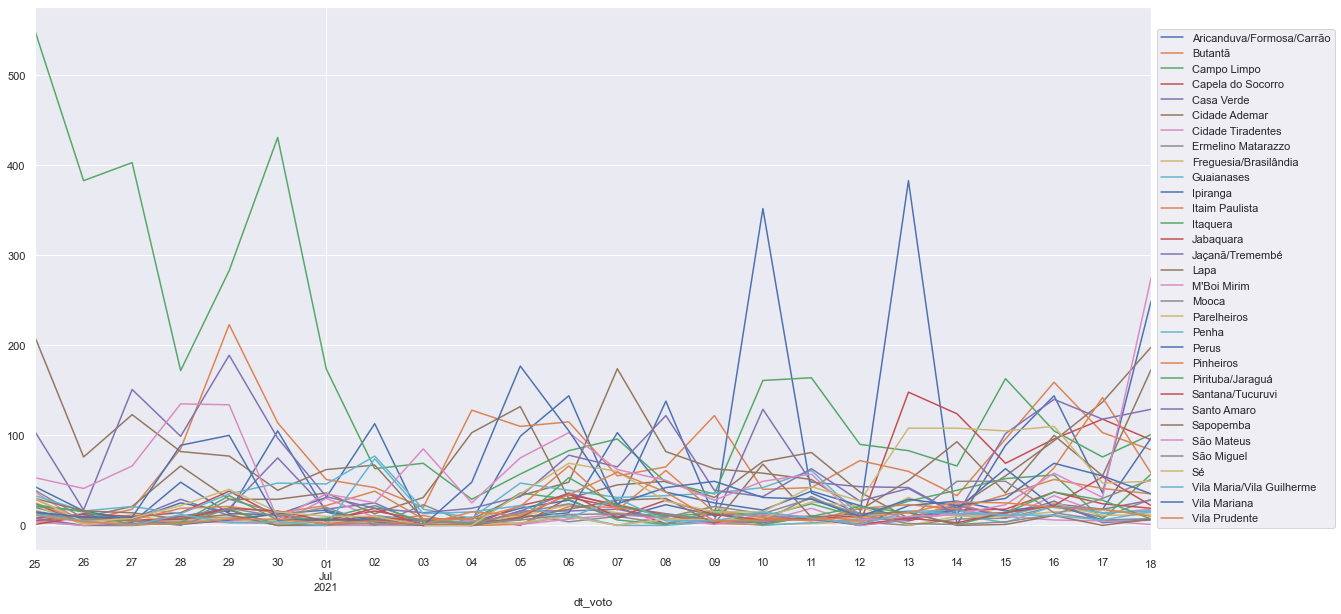

In [108]:
votos_por_dia.plot(figsize=(20, 10)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

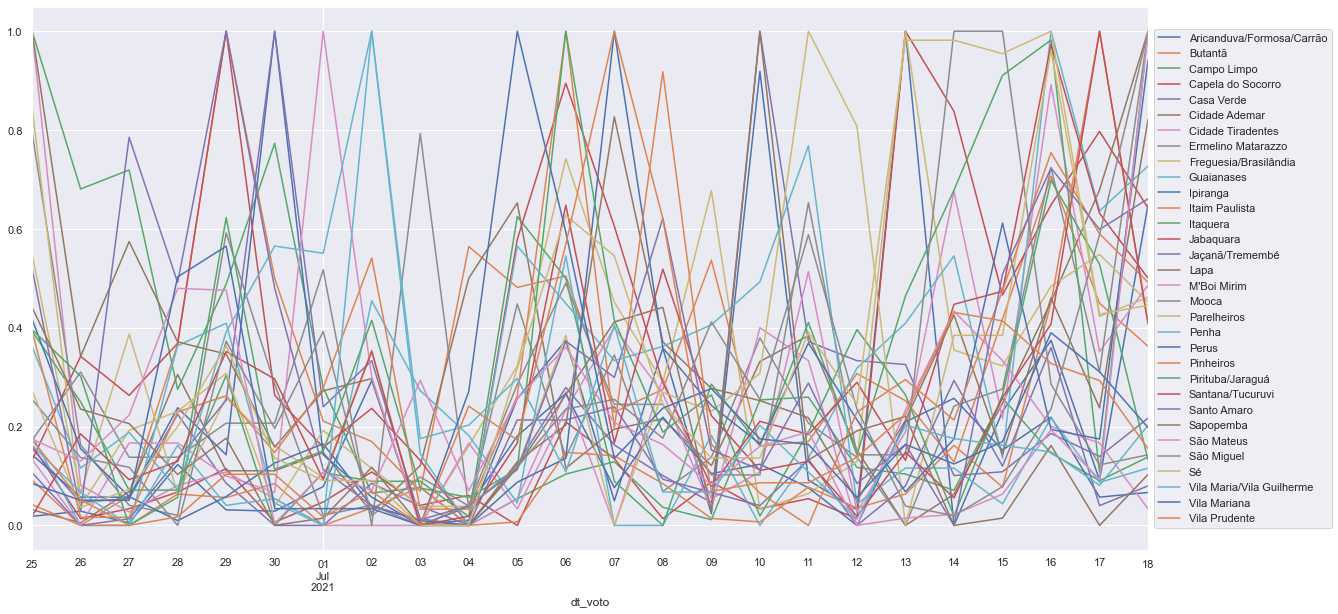

In [109]:
votos_dia_padronizado.plot(figsize=(20, 10)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

<AxesSubplot:xlabel='subprefeitura', ylabel='subprefeitura'>

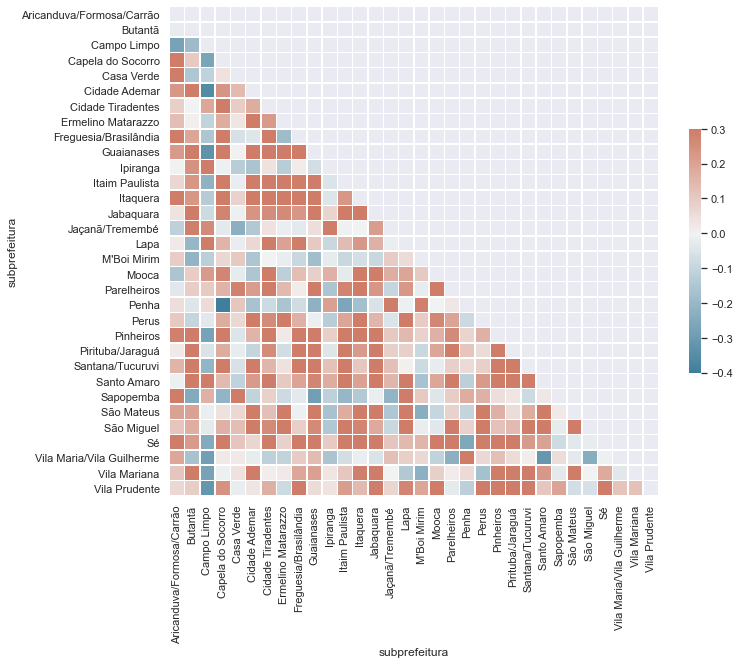

In [110]:
corr = votos_por_dia.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [111]:
pd.DataFrame(corr['São Mateus'].sort_values(ascending=False))

,São Mateus
subprefeitura,
São Mateus,1.000000
São Miguel,0.568273
Ermelino Matarazzo,0.567098
Cidade Ademar,0.548022
Santo Amaro,0.454838
Lapa,0.418265
Perus,0.370246
Jabaquara,0.368435
Itaquera,0.349295


In [112]:
from scipy.stats import ks_2samp

In [113]:
subs_dist_igual = []
for subs in votos_por_dia.columns:
    teste = ks_2samp(votos_por_dia['São Mateus'], votos_por_dia[subs])
    if teste[1]>0.05:
        print(teste)
        print(subs)
        subs_dist_igual.append(subs)

KstestResult(statistic=0.2916666666666667, pvalue=0.26283384201555077)
Aricanduva/Formosa/Carrão
KstestResult(statistic=0.25, pvalue=0.4490368220409109)
Butantã
KstestResult(statistic=0.125, pvalue=0.994161229482218)
Cidade Ademar
KstestResult(statistic=0.25, pvalue=0.4490368220409109)
Lapa
KstestResult(statistic=0.25, pvalue=0.4490368220409109)
Santo Amaro
KstestResult(statistic=0.0, pvalue=1.0)
São Mateus
KstestResult(statistic=0.25, pvalue=0.4490368220409109)
Sé
KstestResult(statistic=0.25, pvalue=0.4490368220409109)
Vila Mariana


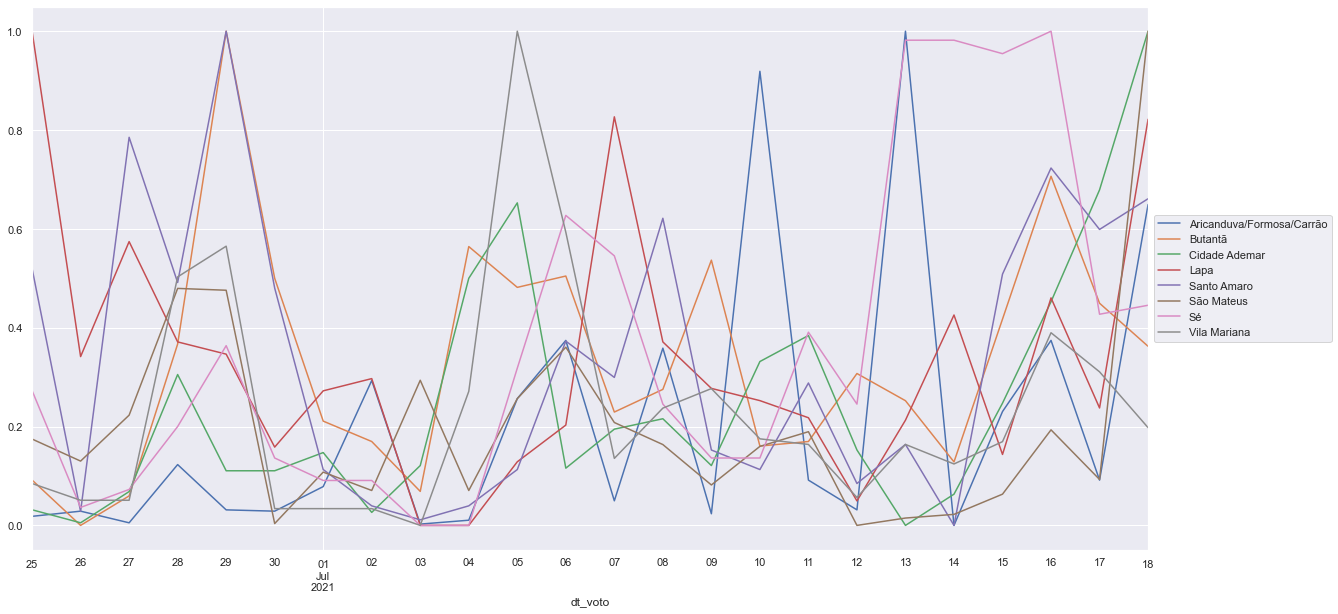

In [119]:
votos_dia_padronizado[subs_dist_igual].plot(figsize=(20, 10)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

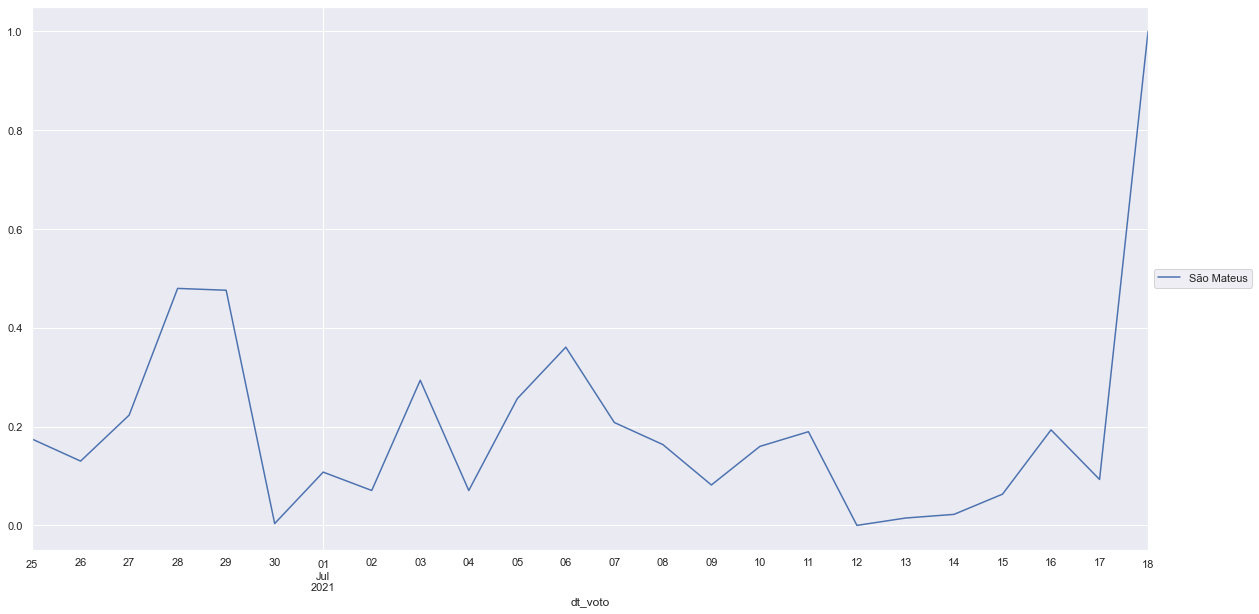

In [231]:
votos_dia_padronizado['São Mateus'].plot(figsize=(20, 10)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [233]:
'''Em sao matheus, houve mais de um voto para um mesmo cpf para uma mesma proposta '''

'Em sao matheus, houve mais de um voto para um mesmo cpf para uma mesma proposta '

In [241]:
df['count']=1

In [244]:
df[df['subprefeitura']=='São Mateus'].groupby(['Título', 'documento']).count()[['count']]['count'].unique()

array([1])

In [296]:
sao_mateus = df[df['subprefeitura']=='São Mateus'].copy()

In [297]:
sao_mateus['dt_voto'] = sao_mateus['Data do voto'].apply(pd.to_datetime, dayfirst = True)

In [298]:
sao_mateus['count'] = 1

In [299]:
votos_por_dia = sao_mateus.groupby(['Título', 'dt_voto']).count()[['count']].reset_index()

In [300]:
votos_por_dia = votos_por_dia.sort_values(by=['Título', 'dt_voto'])

In [301]:
votos_por_dia['acumulado'] = 0
titulo = votos_por_dia.iloc[0]['Título']
acumulado = 0

for i, row in votos_por_dia.iterrows():
    novo_titulo = row['Título']
    if titulo == novo_titulo:
        acumulado+=row['count']
        votos_por_dia.loc[i, 'acumulado'] = acumulado
    else:
        acumulado = 0
        titulo = novo_titulo

In [304]:
pd.set_option('display.max_rows', None)

In [306]:
votos_por_dia.head()

,Título,dt_voto,count,acumulado
0,Construção de projetos estruturantes de Assist...,2021-06-28,1,1
1,Construção de projetos estruturantes de Assist...,2021-06-29,1,2
2,Construção de projetos estruturantes de Assist...,2021-07-02,1,3
3,Construção de projetos estruturantes de Assist...,2021-07-07,1,4
4,Construção de projetos estruturantes de Assist...,2021-07-08,2,6


In [308]:
votos_por_dia_viz = votos_por_dia.pivot(index='dt_voto', columns='Título', values='acumulado')

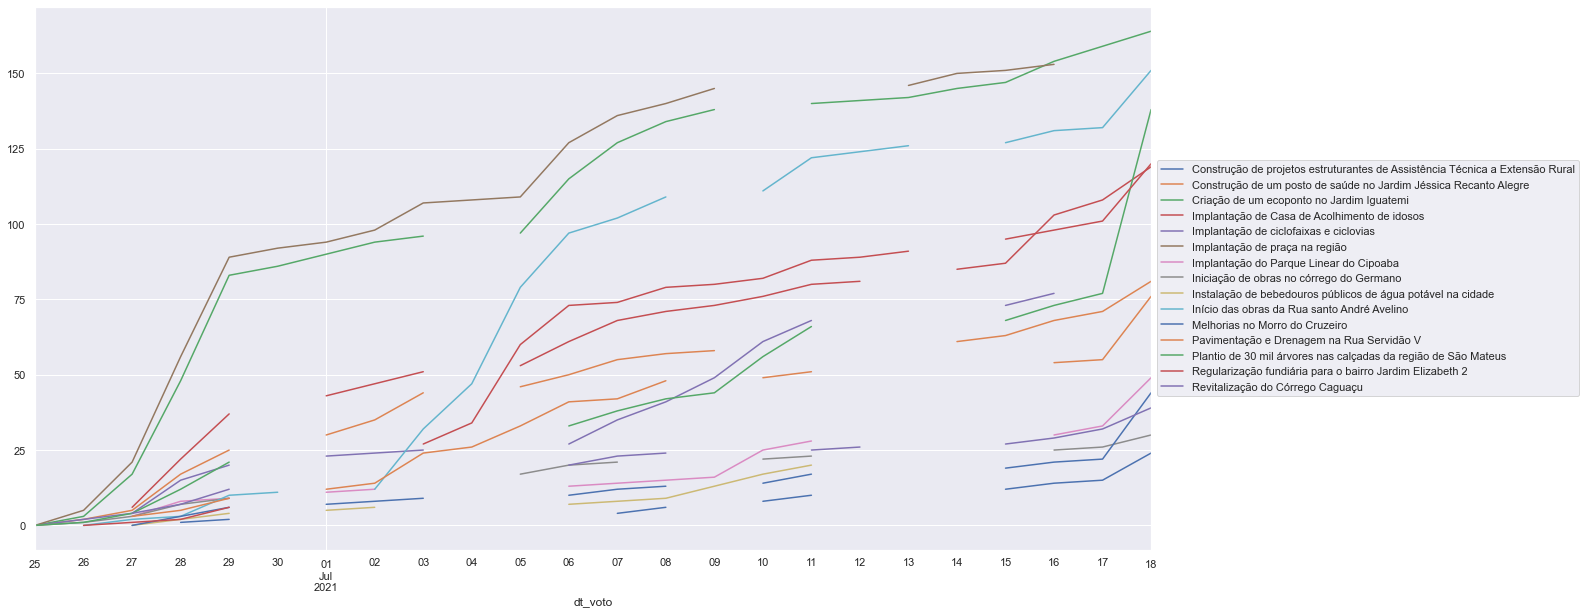

In [316]:
fig = votos_por_dia_viz.plot(figsize=(20, 10))
fig.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [323]:
fig.get_figure().savefig('mapa_propostas_sao_mateus.png')

In [254]:
ordem_propostas = sao_mateus.groupby('Título').count()[['count']].sort_values(by='count', ascending=False)

In [326]:
ordem_propostas.to_excel('ordem_das_propostas_sao_mateus.xlsx')

In [312]:
ordem_propostas.iloc[3]

count    144
Name: Plantio de 30 mil árvores nas calçadas da região de São Mateus, dtype: int64

In [259]:
ordem_propostas.iloc[3] - ordem_propostas.iloc[4]

count    6
dtype: int64

In [324]:
ordem_propostas.iloc[4] - ordem_propostas.iloc[5]

count    4
dtype: int64

In [325]:
ordem_propostas.iloc[5] - ordem_propostas.iloc[6]

count    10
dtype: int64

In [327]:
ordem_propostas.iloc[6]

count    124
Name: Implantação de Casa de Acolhimento de idosos, dtype: int64

In [330]:
ordem_propostas

,count
Título,
Criação de um ecoponto no Jardim Iguatemi,174
Implantação de praça na região,173
Início das obras da Rua santo André Avelino,164
Plantio de 30 mil árvores nas calçadas da região de São Mateus,144
Implantação de ciclofaixas e ciclovias,138
Regularização fundiária para o bairro Jardim Elizabeth 2,134
Implantação de Casa de Acolhimento de idosos,124
Construção de um posto de saúde no Jardim Jéssica Recanto Alegre,83
Pavimentação e Drenagem na Rua Servidão V,78


In [333]:
prop_problemas = list(ordem_propostas.iloc[3:8].index)

In [262]:
'''Identificar qual foi o dia e horário em que a proposta 4 e a 5 passaram na frente da 6 e da 7'''

'Identificar qual foi o dia e horário em que a proposta 4 e a 5 passaram na frente da 6 e da 7'

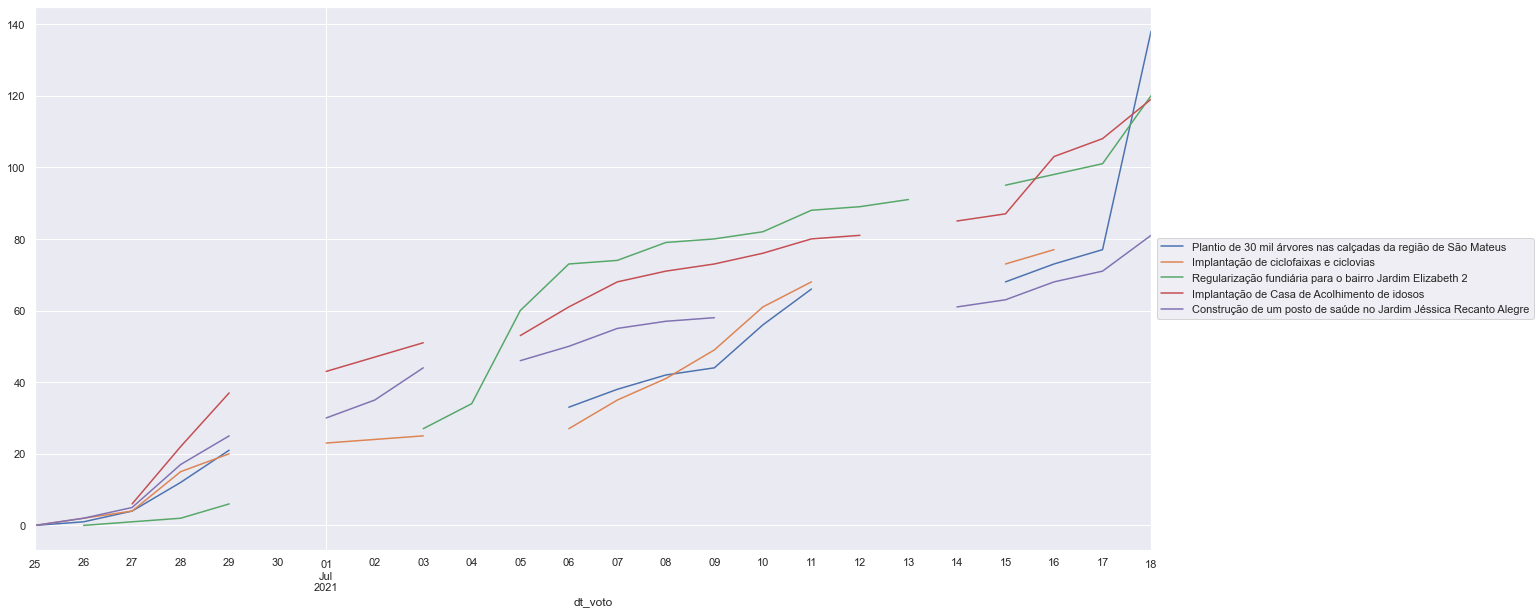

In [336]:
fig = votos_por_dia_viz[prop_problemas].plot(figsize=(20, 10))
fig.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

In [337]:
fig.get_figure().savefig('mapa_propostas_sao_mateus_prop_problemas.png')

In [342]:
sao_mateus[sao_mateus['Título']=='Plantio de 30 mil árvores nas calçadas da região de São Mateus'].groupby('documento').count()[['count']]

,count
documento,
10860454835,1
1281812811,1
1328294870,1
13466576881,1
13688233867,1
14808611899,1
14901728822,1
16135079840,1
16648275871,1
